In [311]:
%matplotlib inline
import os
import shutil

from datetime import datetime

import pandas as pd
import pydotplus
import numpy as np

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics

In [6]:
DATA_DIR = 'data'
FILE_NAMES = {
    'providers':'s', 
    'details': 'p', 
    'supplies': 'sp',
}
files = {k:os.path.join(DATA_DIR, f'{v}.csv') for k, v in FILE_NAMES.items()}

In [7]:
providers = pd.read_csv(files['providers'])
details = pd.read_csv(files['details'])
supplies = pd.read_csv(files['supplies'])

In [8]:
supplies['ShipDate'] = supplies['ShipDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [9]:
all_together = supplies.join(details.set_index('PID'), on='PID').join(providers.set_index('SID'), on='SID')

In [11]:
all_together.T

,0,1,2,3,4,5,6,7,8,9,...,11793,11794,11795,11796,11797,11798,11799,11800,11801,11802
SPID,1,2,3,4,5,6,7,8,9,10,...,11990,11991,11992,11993,11994,11995,11996,11997,11998,11999
SID,714,812,1,1036,226,58,779,1087,730,418,...,1014,634,680,269,961,892,573,671,417,299
PID,603,648,265,114,1005,862,748,509,999,644,...,778,645,358,622,243,769,415,642,989,569
Quantity,35,23,22,250,37,8,33,45,31,45,...,331,531,34,67,437,209,48,347,1,33
Price,259.824,420.85,313.93,256.28,441.47,28.65,416.86,383.36,245.89,98.65,...,157.57,89.52,119.04,247.69,392,308.42,103.88,163.18,152.98,86.93
ShipDate,2014-04-23 00:00:00,2013-08-29 00:00:00,2015-01-21 00:00:00,2013-03-07 00:00:00,2013-03-17 00:00:00,2013-10-09 00:00:00,2014-09-29 00:00:00,2013-01-07 00:00:00,2012-06-14 00:00:00,2013-03-29 00:00:00,...,2012-10-28 00:00:00,2014-01-18 00:00:00,2014-06-09 00:00:00,2014-09-19 00:00:00,2014-03-03 00:00:00,2013-03-30 00:00:00,2012-11-28 00:00:00,2013-05-14 00:00:00,2013-05-26 00:00:00,2013-03-09 00:00:00
PName,Стальной лист,Кожух,Шуруп,Ремень,Поручень,Колесо,Ручка,Поручень,Радиатор,Отвёртка,...,Гвоздь,Верёвка,Труба,Колесо,Леска,Болт,Шина,Ремень,Поручень,Шуруп
PCity,Екатеринбург,Владивосток,Саратов,Воронеж,Самара,Пермь,Владивосток,Ростов-на-Дону,Ярославль,Барнаул,...,Екатеринбург,Ульяновск,Челябинск,Иркутск,Ижевск,Барнаул,Саратов,Тольятти,Воронеж,Барнаул
Color,Красный,Жёлтый,Серый,Зелёный,Жёлтый,Красный,Серый,Синий,Синий,Чёрный,...,Красный,Красный,Красный,Серый,Синий,Серый,Зелёный,Синий,Зелёный,Зелёный
Weight,11.226,19.232,1.586,0.945,19.466,14.291,0.809,19.415,12.911,0.801,...,1.853,1.768,19.636,11.777,0.875,1.106,14.959,1.681,14.789,0.54


1) Название поставщика  
2) Город поставщика  
3) Ассортимент - вычисляется как дециль количества различных товаров, поставляемых данным поставщиком  
4) Вал - вычисляется как дециль суммарного количества товаров, поставленных данным поставщиком  
4) Оборот - вычисляется как дециль суммарной стоимости всех товаров, поставленных данным поставщиком  
5) Надежность - вычисляется: "Yes" в случае Risk=3 или "No" иначе (классификационный атрибут). 

In [256]:
data = pd.DataFrame()

#### Название поставщика

In [257]:
data['Название поставщика'] = all_together['SName']

#### Город поставщика

In [258]:
data['Город поставщика'] = all_together['SCity']

#### Ассортимент
Вычисляется как дециль количества различных товаров, поставляемых данным поставщиком

In [259]:
ranges = all_together[['SName','SCity','PName']].groupby(['SName', 'SCity']).aggregate(lambda x: x.nunique() / 10)
ranges['Ассортимент'] = ranges['PName']
ranges = ranges.drop(['PName'], axis=1)

In [260]:
data = data.join(ranges, on=['Название поставщика', 'Город поставщика'], sort=False)

#### Вал
Вычисляется как дециль суммарного количества товаров, поставленных данным поставщиком

In [261]:
shaft = all_together[['SName','SCity','Quantity']].groupby(['SName', 'SCity']).aggregate(lambda x: np.sum(x.values) / 10)
shaft['Вал'] = shaft['Quantity']
shaft = shaft.drop(['Quantity'], axis=1)

In [262]:
data = data.join(shaft, on=['Название поставщика', 'Город поставщика'], sort=False)

#### Оборот
Вычисляется как дециль суммарной стоимости всех товаров, поставленных данным поставщиком

In [263]:
all_together['total_price'] = all_together.apply(lambda x: x['Quantity'] * x['Price'], axis=1)

In [264]:
circulation = all_together[['SName','SCity','total_price']].groupby(['SName', 'SCity']).aggregate(lambda x: np.sum(x.values) / 10)
circulation['Оборот'] = circulation['total_price']
circulation = circulation.drop(['total_price'], axis=1)

In [265]:
data = data.join(circulation, on=['Название поставщика', 'Город поставщика'], sort=False)

#### Надежность
Вычисляется: "Yes" в случае Risk=3 или "No" иначе (классификационный атрибут).

In [266]:
data['Надежность'] = all_together['Risk'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [267]:
data.head()

,Название поставщика,Город поставщика,Ассортимент,Вал,Оборот,Надежность
0,"ГК ""Эталон""",Воронеж,1.3,403.5,74439.372056,No
1,﻿Синапсис,Пермь,1.5,509.8,127584.927000,No
2,Янус,Санкт-Петербург,1.2,273.2,50970.750000,Yes
3,﻿Синапсис,Волгоград,1.3,552.4,120065.989000,No
4,"ООО ""ВиК-инжиниринг""",Санкт-Петербург,1.0,500.5,161811.694000,No


In [268]:
categorical_feature_names = ['Название поставщика', 'Город поставщика']
target_feature_name = 'Надежность'
num_feature_names = list(data.drop(categorical_feature_names + [target_feature_name], axis=1).columns.values)
num_feature_names

['Ассортимент', 'Вал', 'Оборот']

In [269]:
num_features = data[num_feature_names]
num_features.head()

,Ассортимент,Вал,Оборот
0,1.3,403.5,74439.372056
1,1.5,509.8,127584.927000
2,1.2,273.2,50970.750000
3,1.3,552.4,120065.989000
4,1.0,500.5,161811.694000


In [270]:
encoder = OneHotEncoder(sparse=False)

In [271]:
cat_features = encoder.fit_transform(data[categorical_feature_names])

In [272]:
cat_df = pd.DataFrame({k: v for k, v in zip(encoder.get_feature_names(), cat_features.T)})

In [273]:
features = pd.concat([num_features, cat_df], axis=1, sort=False)

In [274]:
features_names = list(features.columns.values)

In [279]:
target = data[target_feature_name]

In [282]:
data_x, data_y = features.values, target.values

In [287]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)

In [288]:
clf_tree = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=None, 
    random_state=17,
)

In [289]:
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [290]:
class_names = clf_tree.classes_

In [313]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [314]:
test_predicts = clf_tree.predict(x_test)

Confusion matrix, without normalization
[[2109  296]
 [ 339  797]]


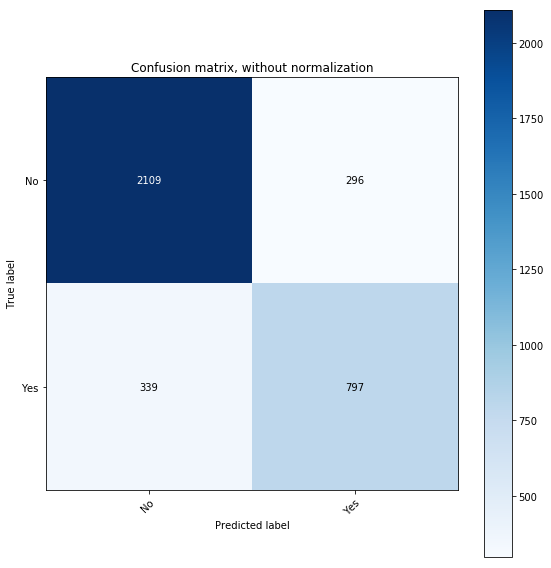

In [315]:
plot_confusion_matrix(y_test,test_predicts , class_names)

In [321]:
yes_no_to_1_0 = lambda x: 1 if x == 'Yes' else 0
expect, actual = list(map(yes_no_to_1_0, y_test)), list(map(yes_no_to_1_0, test_predicts))

In [328]:
accuracy = metrics.accuracy_score(expect, actual)
precision = metrics.precision_score(expect, actual)
recall = metrics.recall_score(expect, actual)
f1 = metrics.f1_score(expect, actual)

- Доля правильных ответов: `{{'%.5f' % accuracy}}`  
- Точность: `{{'%.5f' % precision}}`  
- Полнота: `{{'%.5f' % recall}}`    
- F-мера (F1): `{{'%.5f' % f1}}`  